## Identify targeting consumer groups

In this project, unsupervised learning techniques were applied to identify targeting consumer groups for protein beverage products launched in 2020-2023. Supervised learning techniques were employed to identify the most popular ingredients for products targeting specific consumer group. The data was sourced from a market research company and represents a real-life data science task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re

In [ ]:
# This is only for the web app; Not necessary to import
import streamlit as st

!streamlit run app.py

***

### Step 1: Data loading and pre-processing

In [2]:
df_excel = pd.read_excel('protein_beverages_and_sport_drinks.xls', sheet_name = 'Innova', dtype={'Product Id':str})

In [3]:
df_excel.shape

(19240, 46)

In [4]:
data_raw = df_excel.drop_duplicates(subset = ['Product Id','Company','Product Name'])

#### Remove 'fake' New Products
Product event, such as "import", "shelf snapshots", and "new package", are not really New Product Launch, which are removed from the dataset.

In [ ]:
data_raw['Event'].value_counts()

In [7]:
new_product_data = data_raw[(data_raw['Event'] == 'New Product') | (data_raw['Event'] == 'Reformulation')]
new_product_data['Claims/Features'].info() #The product 'Claims/Features' column only has 3 null values out of 11,443 entries

<class 'pandas.core.series.Series'>
Index: 11443 entries, 0 to 19239
Series name: Claims/Features
Non-Null Count  Dtype 
--------------  ----- 
11440 non-null  object
dtypes: object(1)
memory usage: 178.8+ KB


***

### Step 2: Topic Modeling by LDA Method

#### Step 2.1: Column 'Claims/Features' provides detailed product description and features. The texts were processed using customized tokenizer and screened through a list of customized "stop words" based on `spacy`

In [7]:
#Using gensim can extract more information about the resulting generative model than using scikit-learn's LDA class
import gensim

In [8]:
product_features = new_product_data[['Claims/Features']].astype('string').dropna()
product_features.info()
feature_text = product_features['Claims/Features'].values.tolist()

<class 'pandas.core.frame.DataFrame'>
Index: 11440 entries, 0 to 19239
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Claims/Features  11440 non-null  string
dtypes: string(1)
memory usage: 178.8 KB


In [13]:
# Stop_Words = stopwords.difference({'no','free'}) # remove 'no' and 'free' from the stopwords
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])
stopwords = spacy.lang.en.stop_words.STOP_WORDS                     
#stopwords = stopwords.difference({'he','his','her','hers'}) # Removing a few words that don't lemmatize well
stopwords.update(['v', 'l', 'mg', 'base', 'add', 'serve', 'beta', 'contain', '.',
                 'd', 'll', 'm', 'n', 's', 've', '‘t', '’t', 't', ':']) # Customize the stopwords

def process_words(text, stop_words=set()):
    result = []
    for t in text:
        doc = ' '.join(re.findall(r'\b\D[a-zA-Z\'\/]*\b', t))
        result.append([token.lemma_.lower() for token in nlp(doc) if token.lemma_ not in stop_words])
        #result.append([token for token in tokens if token not in stop_words])
    return result

processed_text = process_words(feature_text, stop_words=stopwords.union(['-PRON-','serving','levels','suitable',
                                                                         '-', ' ','  ','   ','ingredient','product']))

In [14]:
dictionary = gensim.corpora.Dictionary(processed_text)
print(f'Number of unique tokens: {len(dictionary)}')
corpus = [dictionary.doc2bow(t) for t in processed_text]

Number of unique tokens: 9004


#### Step 2.2: Find the dominant topics of product description/features for new products launched Globally
Based on the coherence scores and checking the top words, it seems that 3 is the right number of topics

In [ ]:
# Use the coherence score provided by the gensim package to optimize the number of topics
# coherence is supposed to model "human interpretability" of topics

coherence_scores = []
for n in range(3, 11):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

In [ ]:
coherence_scores

In [97]:
lda_model_3 = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=3, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

In [98]:
from pprint import pprint

pprint(lda_model_3.print_topics(num_words=15))

[(0,
  '0.094*"protein" + 0.020*"high" + 0.019*"muscle" + 0.018*"whey" + '
  '0.017*"amino" + 0.016*"acid" + 0.015*"vegan" + 0.012*"vegetarian" + '
  '0.012*"sugar" + 0.011*"quality" + 0.010*"bcaa" + 0.010*"flavor" + '
  '0.010*"mass" + 0.009*"low" + 0.009*"source"'),
 (1,
  '0.031*"certify" + 0.031*"plant" + 0.029*"sugar" + 0.025*"organic" + '
  '0.025*"gluten" + 0.020*"lactose" + 0.018*"vegan" + 0.018*"dairy" + '
  '0.017*"vitamin" + 0.017*"certified" + 0.017*"calcium" + 0.016*"naturally" + '
  '0.016*"recyclable" + 0.015*"source" + 0.013*"soy"'),
 (2,
  '0.029*"muscle" + 0.015*"energy" + 0.012*"help" + 0.011*"body" + '
  '0.011*"normal" + 0.010*"support" + 0.010*"increase" + 0.010*"recovery" + '
  '0.009*"performance" + 0.009*"caffeine" + 0.009*"acid" + 0.009*"contribute" '
  '+ 0.008*"bcaa" + 0.008*"vitamin" + 0.007*"fatigue"')]


In [17]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        #keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text')],axis=1) 
                           #pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [99]:
main_topic_df = get_main_topic_df(lda_model_3, corpus, processed_text)

In [ ]:
main_topic_df.info()

In [ ]:
product_features.info()

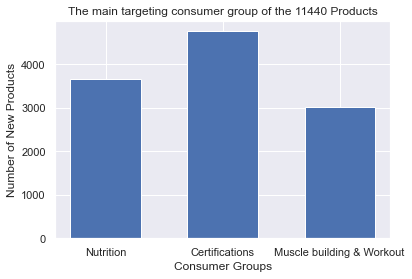

In [103]:
plt.bar(['Nutrition','Certifications','Muscle building & Workout'], grouped_topics.count()['Processed_text'].to_list(), width=0.6)
plt.title(f'The main targeting consumer group of the {len(feature_text)} Products')
plt.ylabel('Number of New Products')
plt.xlabel('Consumer Groups')
plt.savefig('global_plot.png')

In [119]:
lda_top_words_index = set()
for i in range(lda_model_3.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model_3.get_topic_terms(i)])
    
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]

lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Consumer groups'] = main_topic_df['Dominant_topic']
lda_top_words_df.loc[lda_top_words_df['Consumer groups'] == 0, 'Consumer groups'] = 'Nutrition'
lda_top_words_df.loc[lda_top_words_df['Consumer groups'] == 1, 'Consumer groups'] = 'Certifications'
lda_top_words_df.loc[lda_top_words_df['Consumer groups'] == 2, 'Consumer groups'] = 'Muscle building & Workout'

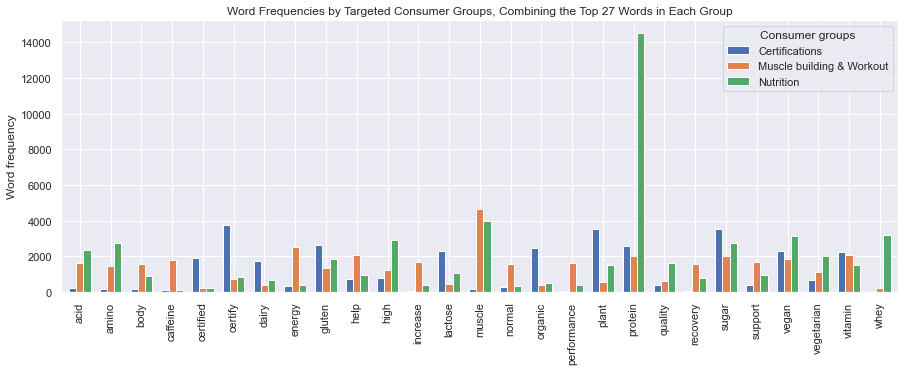

In [139]:
fig = lda_top_words_df.groupby('Consumer groups').sum().transpose().\
         plot(kind='bar', figsize=(15, 5), width=0.7)
fig.set_ylabel('Word frequency')
fig.set_title(f'Word Frequencies by Targeted Consumer Groups, Combining the Top {len(lda_top_words_index)} Words in Each Group')
figure = fig.get_figure()

figure.savefig('global_words.png')

#### Step 2.3: Find the dominant topics of product description/features for new products launched in NA and Europe regions
Skipped the detailed notebook as the process was very similar as above

***

### Step 3: Most Common Ingredients for Each Targeting Consumer Group

In this section, most popular ingredients associated with each targeting consumer group for products launched globally were identified using supervised learning technique - classification.

#### Step 3.1: Build customized tokenizers

Remove ingredients that are flavors, colors, acidity regulators, sweeteners, preservatives, vitamins, minerals, etc, which don't necessarily contribute to the claims of 'dairy alternative' or 'plant based', but at the same time, may occur at a high frequency and impact analysis.

In [5]:
ingredient_stop_words = ['flavor', 'color', 'acid', 'sweetener', 'freshness', 'preservative', 'other ingredient', 'less than',
                  'mineral', 'antioxidant']

# ingredients tokenizer
def splitter_cleaner(line):
    parens = 0
    low = 0
    high = 0
    out = []
    
    for i, c in enumerate(line):
        if c == '(':
            parens += 1
        elif c == ')':
            parens -= 1
            if parens < 0:
                parens = 0
        elif (c == ',' or c =='.') and parens == 0:
            high = i
            word = line[low:high].strip().lower()
            boo = False
            for w in ingredient_stop_words:
                if w in word:
                    boo = boo or True
            if word!= None and (not boo):
                out.append(word)
            low = i + 1
    
    return out

In [161]:
# Build the dataframe
df = main_topic_df[['Dominant_topic', 'Percent']]
features_ingredients = df.rename(columns = {'Dominant_topic': 'dominant_feature', 'Percent': 'per_domination'})
features_ingredients['ingredients'] = new_product_data.dropna(subset=['Claims/Features'])['Ingredients'].astype('string') \
                                        .reset_index(drop = True)  # need to drop index from the 'Ingredients' column, otherwise data is lost
final_df = features_ingredients.dropna()

In [162]:
final_df.head()

,dominant_feature,per_domination,ingredients
1,2,0.814,"BCAA (leucine, isoleucine, valine), beta-alani..."
2,0,0.984,"Whey protein hydrolysate (milk), flavors, acid..."
3,2,0.952,"N-acetyl-l-tyrosine, acetyl-l-carnitine hydroc..."
4,2,0.951,"N-acetyl-l-tyrosine, acetyl-l-carnitine hydroc..."
5,2,0.951,"N-acetyl-l-tyrosine, acetyl-l-carnitine hydroc..."


In [163]:
ingredient_stop_words = ['flavor', 'color', 'acid', 'sweetener', 'sugar', 'freshness', 'preservative', 'other ingredient', 
                         'less than', 'mineral', 'antioxidant', 'salt', 'water', 'sodium chloride', '5%',
                         'sucrose', 'sucralose', 'acesulfame', 'fructose', 'stevia', 'monk fruit']

def has_numbers(string):                           # a function to determine if the ingredient token has numbers
    return any(char.isdigit() for char in string)

# Build ingredients tokenizer + token cleaner
def splitter_cleaner(line):
    parens = 0
    low = 0
    high = 0
    out = []
    
    for i, c in enumerate(line):
        if c == '(':
            parens += 1
        elif c == ')':
            parens -= 1
            if parens < 0:
                parens = 0
        elif (c == ',' or c =='.') and parens == 0:
            high = i
            word = line[low:high].strip().lower()
            in_stopwords = False
            for w in ingredient_stop_words:
                if w in word:
                    in_stopwords = in_stopwords or True
            if word!= None and (not in_stopwords) and (not has_numbers(word)):       
                if word.startswith('l-'):            # remove 'l-' from 'l-amino acid'
                    word = word[2:]                        
                    out.append(word)
                elif word.startswith('organic '):        # remove 'organic' from 'organic (ingredient)'
                    word = word[8:] 
                    out.append(word)
                elif word.endswith(' (bcaa)'):        # remove '(bcaa)' from 'amino aicd (bcaa)'
                    word = word[:-7] 
                    out.append(word)
                elif word.startswith('emulsifier ('):        # remove 'emulsifier ()' from 'emulsifier (...)'
                    word = word[12:-1] 
                    out.append(word)
                elif word.startswith('emulsifier: '):
                    word = word[12:] 
                    out.append(word)
                elif word.startswith('stabilizer ('):        # remove 'stabilizer ()' from 'stabilizer (...)'
                    word = word[12:-1] 
                    out.append(word)
                elif word.startswith('stabilizer: '):
                    word = word[12:] 
                    out.append(word)
                elif word.startswith('thickener ('):        # remove 'thickener ()' from 'thickener (...)'
                    word = word[11:-1] 
                    out.append(word)    
                elif word == 'pea protein isolate':        # combine the count of 'pea protein' and 'pea protein isolate'
                    word = 'pea protein'
                    out.append(word)    
                out.append(word)
            low = i + 1
    
    return out

In [164]:
vectorizer = CountVectorizer(tokenizer = splitter_cleaner,
                                    token_pattern = None,)

In [165]:
ingredients_vec = vectorizer.fit_transform(final_df['ingredients'])

ingredients = vectorizer.get_feature_names_out()
counts = np.array(np.sum(ingredients_vec, axis=0))

ingredients_df = pd.DataFrame(zip(ingredients, counts[0]))
ingredients_df.columns = ['ingredient', 'count']
ingredients_df['frequency'] = ingredients_df['count'] / ingredients_df['count'].sum()

In [55]:
ingredients_df.sort_values(by = 'frequency', ascending = False)[:60]

,ingredient,count,frequency
6998,valine,1987,0.025760
3865,leucine,1909,0.024749
3615,isoleucine,1896,0.024581
6968,tyrosine,1665,0.021586
6505,sunflower lecithin,1557,0.020186
2906,gellan gum,1525,0.019771
4319,methionine,1510,0.019576
5075,phenylalanine,1477,0.019148
6920,tryptophan,1468,0.019032
6800,threonine,1390,0.018021


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

idf_vectorizer = TfidfVectorizer(tokenizer = splitter_cleaner,
                                    token_pattern = None,
                                    min_df = 2,
                                    max_df = 0.95)

optimize_pipe = Pipeline([('idf_vectorizer', idf_vectorizer),
                 ('classifier', MultinomialNB())    
                ])

# Use cross validation to optimize the hyper parameters
best_alpha = GridSearchCV(optimize_pipe, {'classifier__alpha': [0.01, 0.02, 0.05, 0.1]}, cv = 5, n_jobs = -1)

results = best_alpha.fit(final_df['ingredients'], final_df['dominant_feature'])

In [ ]:
# Identified the optimal hyper parameters
results.best_score_, results.best_params_

In [169]:
vectorizer = TfidfVectorizer(tokenizer = splitter_cleaner,
                                    token_pattern = None,
                                    min_df = 5,
                                    max_df = 0.95)
bag_of_words = vectorizer.fit_transform(final_df['ingredients'])
classifier = MultinomialNB(alpha=0.05)
ingredients_model = classifier.fit(bag_of_words, final_df['dominant_feature'])

popular_ingredients = pd.DataFrame((zip(vectorizer.get_feature_names_out(), ingredients_model.feature_log_prob_[0],
                                        ingredients_model.feature_log_prob_[1], ingredients_model.feature_log_prob_[2])))
popular_ingredients.columns = ['ingredients', 'feature_1', 'feature_2', 'feature_3']

In [170]:
popular_ingredients.head()

,ingredients,feature_1,feature_2,feature_3
0,,-8.739977,-9.295941,-9.175859
1,(aquamin),-11.919870,-9.651244,-8.393839
2,"(l-leucine, l-isoleucine, l-valine)]",-7.948806,-11.794488,-11.639113
3,acacia,-11.919870,-7.953933,-7.414200
4,acacia fiber,-7.482431,-6.042397,-7.800635


In [180]:
Feature_1_ingredients = popular_ingredients.sort_values(by=['feature_1'], ascending=False)['ingredients'][:25].tolist()
string = ', '.join(Feature_1_ingredients)
string

'xanthan gum, valine, leucine, isoleucine, methionine, tryptophan, threonine, phenylalanine, histidine, lysine, arginine, proline, glycine, serine, tyrosine, sunflower lecithin, soy lecithin, cysteine, pea protein, glutamine, alanine, inulin, cocoa powder, maltodextrin, whey protein concentrate (milk)'

In [181]:
Feature_2_ingredients = popular_ingredients.sort_values(by=['feature_2'], ascending=False)['ingredients'][:25].tolist()
string = ', '.join(Feature_2_ingredients)
string

'gellan gum, sunflower oil, sunflower lecithin, calcium carbonate, tricalcium phosphate, vitamin d, pea protein, rapeseed oil, guar gum, locust bean gum, maltodextrin, xanthan gum, dipotassium phosphate, calcium phosphate, calcium, vitamin e, vitamin a palmitate, gellan, vitamin a, carrageenan, cocoa powder, almonds, inulin, zinc gluconate, potassium citrate'

In [182]:
Feature_3_ingredients = popular_ingredients.sort_values(by=['feature_3'], ascending=False)['ingredients'][:30].tolist()
string = ', '.join(Feature_3_ingredients)
string

'taurine, tyrosine, isoleucine, valine, citrulline, leucine, maltodextrin, silicon dioxide, beta-alanine, glutamine, theanine, sodium citrate, citrulline malate, creatine monohydrate, potassium citrate, caffeine, caffeine anhydrous, arginine, cluster dextrin (maltodextrin), anti-caking agent (silicon dioxide), sunflower lecithin, palatinose (isomaltulose), potassium chloride, magnesium citrate, calcium silicate, phenylalanine, tryptophan, dextrose, xanthan gum, threonine'

### Appendix: Topic modeling of 'Product features/claims' by K-means clustering method - Not implemented for this project, but shown here to demonstrate another approach for topic modeling.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

# lemmatizer was not used here as it created issues
def my_tokenizer(doc):                                             # Build custom tokenizer
    return ' '.join(re.findall(r'\b\D[a-zA-Z\'\/\-]*\b', doc)).lower().split()

stopwords = spacy.lang.en.stop_words.STOP_WORDS                     
#stopwords = stopwords.difference({'he','his','her','hers'}) # Removing a few words that don't lemmatize well
stopwords.update(['v', 'l', 'mg', 'base', 'free', 'pre', 'add', 'serve', 'beta', 'contain', '.',
                 'd', 'll', 'm', 'n', 's', 've', '‘t', '’t', 't', ':']) # Customize the stopwords
  

In [ ]:
# Vectorize the text and determine weight of the tokens
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np

max_features = 2000

vectorizer = CountVectorizer(tokenizer=my_tokenizer, stop_words=list(stopwords),
                             #ngram_range=(1,2),
                             min_df=2, max_df=0.95, max_features=max_features,
                             token_pattern=None)
counts = vectorizer.fit_transform(product_features['Claims/Features'])

idf = TfidfTransformer()
idf_matrix = idf.fit_transform(counts)

In [ ]:
words = vectorizer.get_feature_names_out()
print('g' in words)  

In [ ]:
# Determine clusters of product features/claims using K-means clustering
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(idf_matrix)

In [ ]:
# Check list of words for each cluster

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
words = vectorizer.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print(f'Cluster {i}: ')
    print(', '.join([words[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([words[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

In [ ]:
# Check scores of different numbers of clustering
words = vectorizer.get_feature_names_out()
word_df = pd.DataFrame()

for n in range(2, 16):
    kmc = KMeans(n_clusters=n, n_init=3, random_state=117)  # random_state for consistency
    kmc.fit(idf_matrix)
    word_df['Cluster'] = pd.DataFrame(kmc.labels_.tolist())
    print(f'Clusters: {n}  Silhouette score: {silhouette_score(idf_matrix, word_df["Cluster"])}')

In [ ]:
# Check top words of Cluster 3 and 10, based on the silhouette scores and consideration of manageable amount of clusters

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmc_3 = KMeans(n_clusters=3, n_init=3, random_state=117) 
kmc_3.fit(idf_matrix)

number_of_top_words = 20

cluster_words = np.argsort(kmc_3.cluster_centers_, axis=1)
words = vectorizer.get_feature_names_out()

top_words = set()

for i in range(3):
    print(f'Cluster {i}: ')
    print(', '.join([words[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([words[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words_3_clusters = sorted(list(top_words))

In [ ]:
# Size of clusters for 3-Cluster model

word_df_3 = pd.DataFrame(counts.toarray(), columns=words)[top_words_3_clusters]
word_df_3['Cluster'] = kmc_3.labels_.tolist()

word_df_3.groupby('Cluster').count()[top_words_3_clusters[0]].\
    plot.bar(rot=0).\
    set(ylabel='Product count',
    title='Number of Products per Cluster');

In [ ]:
kmc_10 = KMeans(n_clusters=10, n_init=3, random_state=117)  # random_state for consistency
kmc_10.fit(idf_matrix)

number_of_top_words = 10

cluster_words = np.argsort(kmc_10.cluster_centers_, axis=1)
words = vectorizer.get_feature_names_out()

top_words = set()

for i in range(10):
    print(f'Cluster {i}: ')
    print(', '.join([words[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([words[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words_10_clusters = sorted(list(top_words))

In [ ]:
# Size of clusters for 10-Cluster model

word_df_10 = pd.DataFrame(counts.toarray(), columns=words)[top_words_10_clusters]
word_df_10['Cluster'] = kmc_10.labels_.tolist()

word_df_10.groupby('Cluster').count()[top_words_10_clusters[0]].\
    plot.bar(rot=0).\
    set(ylabel='Product count',
    title='Number of Products per Cluster');